# Local Thresholding
In this notebook, I extract orbits for a signle chromosome in all 4 cell lines, using a
different method of thresholding.
In order to do this, I slide a kernel of size k 
through each pixel and check if it has a 
particular property. If the property is satisified, then the pixel is set to 1,
otherwise it is set to 0. 
The two properties that I experiment with are *maximum thresholding* and *normal 
thresholding*.
1. **Maximum Thresholding**: in max thresholding, if the pixel is the maximum of its 
neighbors with respect to the kernel, then it is set.

```python
def local_threshold(mat, k=1, method='max', t=1):
    mat2 = np.zeros_like(mat)
    n, m = mat.shape
    if isinstance(k, tuple):
        k1, k2 = k
    else:
        k1 = k2 = k
    for i in range(k1, n-k1):
        for j in range(k, m-k2):
            if method == 'max':
                condition = mat[i, j] == np.max(mat[i-k1:i+k1, j-k2:j+k2])
            elif method=='normal':
                temp = mat[i-k1:i+k1, j-k2:j+k2]
                condition = mat[i, j] >= np.mean(temp) + t * np.std(temp)
            elif method = 'max_linear':
                condition = mat[i, j] == np.max(mat[i, j-k1:j+k2])
            if condition:
                mat2[i, j] = 1
    return mat2
```
2. **Normal Thresholding**: in normal thresholding, if the pixel is larger that the 
average of the neighbors then it is set.

In [1]:
import numpy as np
import cv2
from library.utility import *
import matplotlib.pyplot as plt
from iced import normalization
from iced import filter
from sets import Set
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/git/watson/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading Data
The first step is to load the raw Hi-C contact maps. We have already 
extracted all inter- and intra-chromosomal contact maps and compiled them 
into as single large numpy array format.

Number of rows and columns: 2, 2
(4, 4)


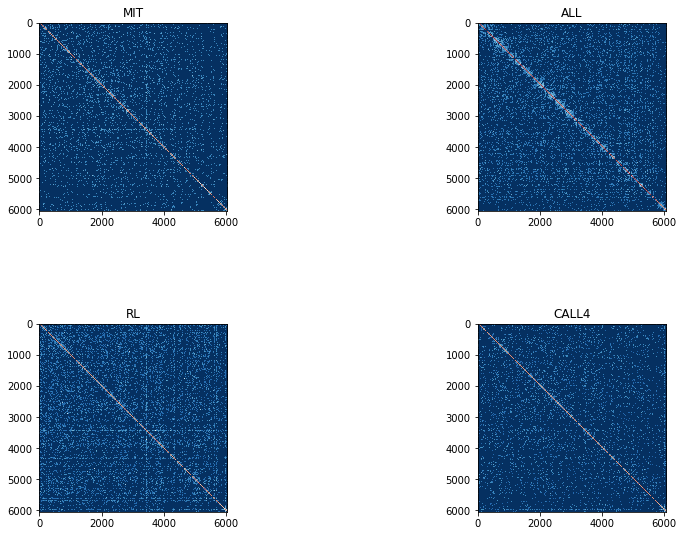

In [2]:
pylab.rcParams['figure.figsize'] = (15, 9)

lengths_low_res = np.load('../numpy_data/length_low_res.npy')
mit_full  = (np.load('../numpy_data/mit_low_res.npy'))
all_full  = (np.load('../numpy_data/all_low_res.npy'))
rl_full  = (np.load('../numpy_data/rl_low_res.npy'))
call4_full  = (np.load('../numpy_data/call4_low_res.npy'))
data = {}
showImages([mit_full , all_full , rl_full , call4_full ], rows=2, titles=['MIT', 'ALL', 'RL', 'CALL4'])

# Selecting a inter-/intra-chromosomal contact map
You can chang chr1 and chr2 variables based on the contact map you want to investigate.

Number of rows and columns: 2, 2
(4, 4)


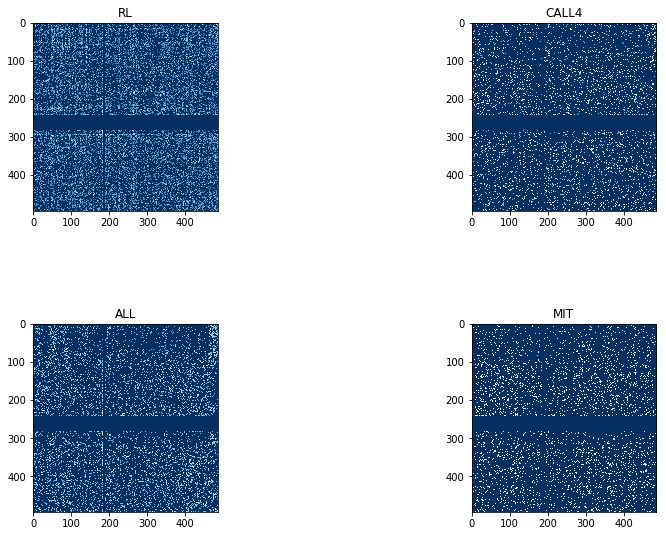

In [3]:
chr1 = 1
chr2 = 2
data['MIT']          = get_contact_map(mit_full        , lengths_low_res, chr1, chr2)
data['ALL']          = get_contact_map(all_full        , lengths_low_res, chr1, chr2)
data['RL']           = get_contact_map(rl_full         , lengths_low_res, chr1, chr2)
data['CALL4']        = get_contact_map(call4_full      , lengths_low_res, chr1, chr2)
showImages(data, rows = 2, titles=['MIT', 'ALL', 'RL', 'CALL4'])

## Cleaning Data
As can be observed above, there are several rows and columns that simply don't contain any data and are all zeros, in the following code we clean the matrices to remove these zero rows and columns since they will cause problems in future analysis.

In [4]:
#There are some blank rows and columns in the matrix. let's remove them.
blankRows0, blankCols0 = getBlankRowsAndColumns(data['MIT'])
blankRows1, blankCols1 = getBlankRowsAndColumns(data['ALL'])
blankRows2, blankCols2 = getBlankRowsAndColumns(data['RL'])
blankRows3, blankCols3 = getBlankRowsAndColumns(data['CALL4'])
blankRows = Set([])
blankCols = Set([])
blankRows.update(blankRows0)
blankRows.update(blankRows1)
blankRows.update(blankRows2)
blankRows.update(blankRows3)
blankCols.update(blankCols0)
blankCols.update(blankCols1)
blankCols.update(blankCols2)
blankCols.update(blankCols3)
data['MIT'] = removeRowsAndColumns(data['MIT'], blankRows, blankCols)
data['ALL'] = removeRowsAndColumns(data['ALL'], blankRows, blankCols)
data['RL'] = removeRowsAndColumns(data['RL'], blankRows, blankCols)
data['CALL4'] = removeRowsAndColumns(data['CALL4'], blankRows, blankCols)
n1, m1 = data['MIT'].shape
n2, m2 = data['RL'].shape
n3, m3 = data['ALL'].shape
n4, m4 = data['CALL4'].shape

('size of old matrix:', (495, 486))
('size of new matrix:', (454, 479))
('size of old matrix:', (495, 486))
('size of new matrix:', (454, 479))
('size of old matrix:', (495, 486))
('size of new matrix:', (454, 479))
('size of old matrix:', (495, 486))
('size of new matrix:', (454, 479))


### Comparing CALL4 with RL low-resolution data:
Feel free to change D1 and D2 to pick any data from set of ```['MIT', 'ALL', 'RL', 'CALL4']````.

In [6]:
D1 = 'CALL4'
D2 = 'RL'
pylab.rcParams['figure.figsize'] = (15, 20)
# Size of the kernel
k = (2, 2, 2, 2)
# can be either 'max' for setting the maximum value in each kernel to 1 and the rest to 0
# or 'normal' for setting all values above mean + t * std withing the kernel to 1 and 
# the rest to 0
method = 'normal'
# in case of normal thresholding, t is the coefficient 
# of the standard deviation; that is, n each kernel iteration K
# if K[i, j] > mean(K) + t * std(K), then it is set to 1.
t = 0
params = None
symmetric= chr1==chr2
D1_os = local_threshold(((data[D1]+1+1e-5)), k = k, method=method, t = t, params=params, symmetric=symmetric)
D2_os = local_threshold(((data[D2]+1+1e-5)), k = k, method=method, t = t, params=params, symmetric=symmetric)
n1, m1 = D1_os.shape
n2, m2 = D2_os.shape
n = np.min([n1, n2])
m = np.min([m1, m2])
D1_os = D1_os[:n, :m]
D1_data = data[D1][:n, :m]
D2_os = D2_os[:n, :m]
D2_data = data[D2][:n, :m]
a = ((D1_os * D1_data) > 0) * 1
b = ((D2_os * D2_data) > 0) * 1


(2, 2, 2, 2)
(2, 2, 2, 2)


Number of rows and columns: 2, 3
(6, 6)


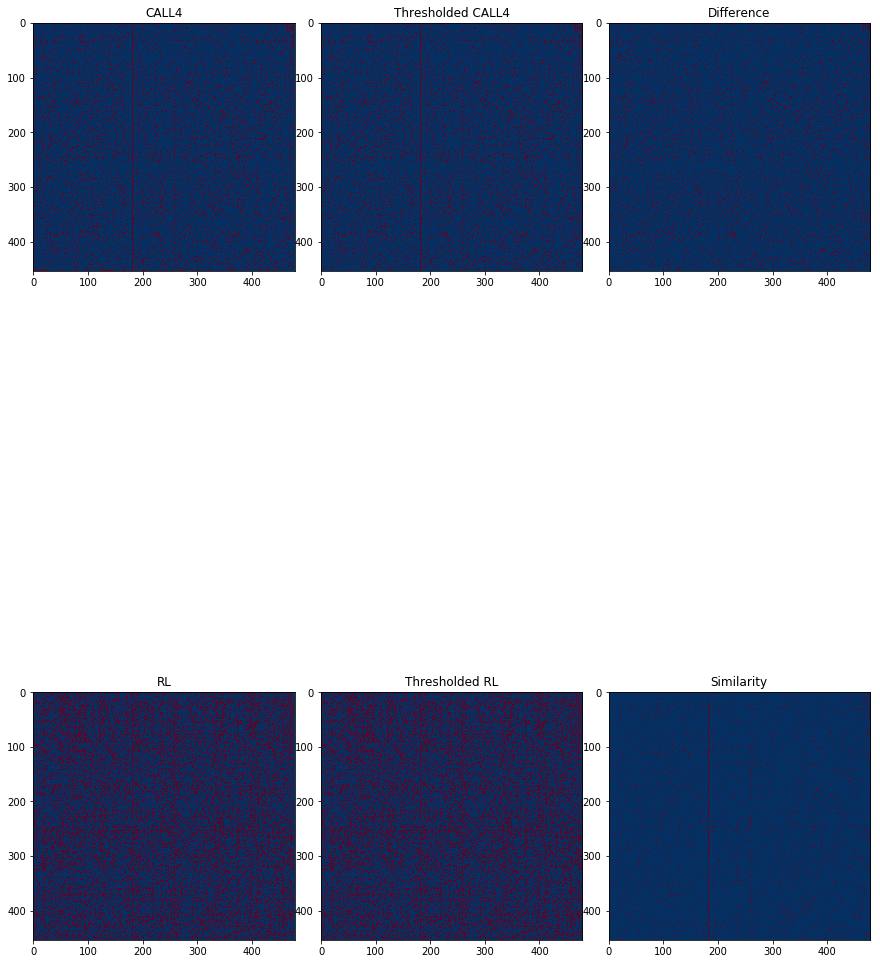

In [8]:
images = [ D1_os, a, (a-b) > 0, D2_os,  b, a * b ]
titles = [D1, 'Thresholded %s'%D1, 'Difference', D2, 'Thresholded %s'%D2, 'Similarity']
showImages(images, 2, titles=titles)